<a href="https://colab.research.google.com/github/bdip635/Histopathology-Classification/blob/main/INCEPTION_RESNET_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix as CMT

In [2]:
!pip install pkbar
import pkbar

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size= 32
device = 'cuda'
num_classes= 4
input_shape=(3,224,224)

In [6]:
main = 'drive/My Drive/Course Project Image Processing - Histopathology/KMC Dataset'
work = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir'

train_dir = os.path.join(main,'Training')
test_dir = os.path.join(main,'Test')
val_dir = os.path.join(main,'Validation')

In [7]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [8]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [9]:
class_dict=train_data.class_to_idx
class_labels = class_dict.values()
print(class_labels)

dict_values([0, 1, 2, 3])


### Plotting the images with classes



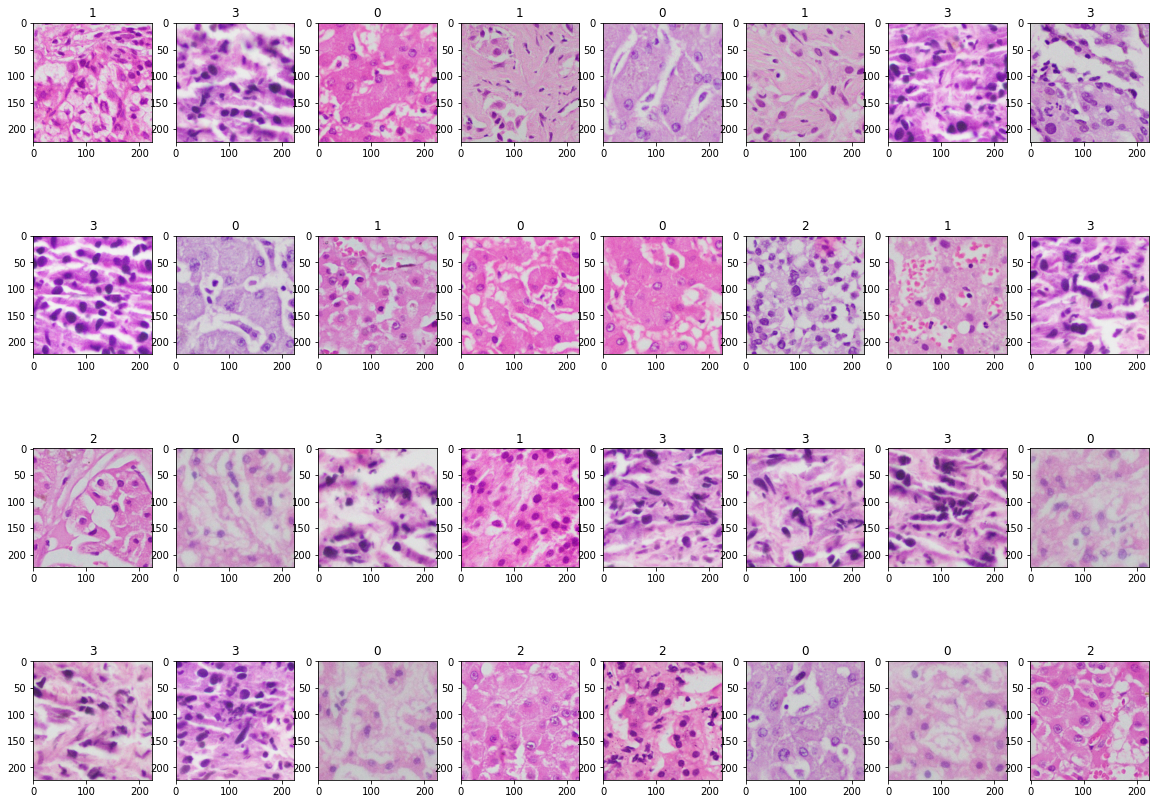

In [11]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

## Model Definition

In [12]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [13]:
class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.features = nn.Sequential(
            Conv2d(in_channels, 32, 3, stride=2, padding=0, bias=False), 
            Conv2d(32, 32, 3, stride=1, padding=0, bias=False), 
            Conv2d(32, 64, 3, stride=1, padding=1, bias=False), 
            nn.MaxPool2d(3, stride=2, padding=0), 
            Conv2d(64, 80, 1, stride=1, padding=0, bias=False), 
            Conv2d(80, 192, 3, stride=1, padding=0, bias=False), 
            nn.MaxPool2d(3, stride=2, padding=0), 
        )
        self.branch_0 = Conv2d(192, 96, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(192, 48, 1, stride=1, padding=0, bias=False),
            Conv2d(48, 64, 5, stride=1, padding=2, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 96, 3, stride=1, padding=1, bias=False),
            Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False)
        )
    def forward(self, x):
        x = self.features(x)
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [14]:
class Inception_ResNet_A(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_A, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        self.conv = nn.Conv2d(128, 320, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)

In [15]:
class Inception_ResNet_B(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_B, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 160, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(160, 192, (7, 1), stride=1, padding=(3, 0), bias=False)
        )
        self.conv = nn.Conv2d(384, 1088, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)

In [16]:
class Inception_ResNet_C(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(Inception_ResNet_C, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False),
            Conv2d(192, 224, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(224, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(448, 2080, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res

In [17]:
class Reduction_A(nn.Module):
    # 35 -> 17
    def __init__(self, in_channels, k, l, m, n):
        super(Reduction_A, self).__init__()
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, k, 1, stride=1, padding=0, bias=False),
            Conv2d(k, l, 3, stride=1, padding=1, bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        return torch.cat((x0, x1, x2), dim=1) # 17 x 17 x 1024

In [18]:
class Reduciton_B(nn.Module):
    def __init__(self, in_channels):
        super(Reduciton_B, self).__init__()
        self.branch_0 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 384, 3, stride=2, padding=0, bias=False)
        )
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            Conv2d(288, 320, 3, stride=2, padding=0, bias=False)
        )
        self.branch_3 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [19]:
class Inception_ResNet_V2(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, k=256, l=256, m=384, n=384):
        super(Inception_ResNet_V2, self).__init__()
        blocks = []
        blocks.append(Stem(in_channels))
        for i in range(10):
            blocks.append(Inception_ResNet_A(320, 0.17))
        blocks.append(Reduction_A(320, k, l, m, n))
        for i in range(20):
            blocks.append(Inception_ResNet_B(1088, 0.10))
        blocks.append(Reduciton_B(1088))
        for i in range(9):
            blocks.append(Inception_ResNet_C(2080, 0.20))
        blocks.append(Inception_ResNet_C(2080, activation=False))
        self.features = nn.Sequential(*blocks)
        self.conv = Conv2d(2080, 1536, 1, stride=1, padding=0, bias=False)
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [20]:
model= Inception_ResNet_V2(num_classes=4).to(device)
summary(model, input_size= (3,224,224), batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 111, 111]             864
       BatchNorm2d-2         [32, 32, 111, 111]              64
              ReLU-3         [32, 32, 111, 111]               0
            Conv2d-4         [32, 32, 111, 111]               0
            Conv2d-5         [32, 32, 109, 109]           9,216
       BatchNorm2d-6         [32, 32, 109, 109]              64
              ReLU-7         [32, 32, 109, 109]               0
            Conv2d-8         [32, 32, 109, 109]               0
            Conv2d-9         [32, 64, 109, 109]          18,432
      BatchNorm2d-10         [32, 64, 109, 109]             128
             ReLU-11         [32, 64, 109, 109]               0
           Conv2d-12         [32, 64, 109, 109]               0
        MaxPool2d-13           [32, 64, 54, 54]               0
           Conv2d-14           [32, 80,

In [37]:
learning_rate = 1e-5
num_epochs = 50

In [22]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [24]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location=torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [34]:
model, optimizer = load_checkpoint(model, optimizer, check_pt_file)

In [35]:
check_pt_file = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir/inception_resnet_2.pth.tar'

In [38]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= 0.007

for epoch in range(num_epochs):
  train_losses=[]
### TRAINING
  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:
    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP
    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)
    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION
  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)
  for batch_idx, (data, targets) in val_loop:
    val_losses=[]
    model.eval()
   
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/50
83/83 [==============================] - 61s 734ms/step - loss: 0.0191 - accuracy: 0.9939
Epoch: 1/50
9/9 [==============================] - 3s 290ms/step - val_loss: 0.1835 - val_accuracy: 0.9427
Epoch: 2/50
83/83 [==============================] - 62s 744ms/step - loss: 0.0118 - accuracy: 0.9970
Epoch: 2/50
9/9 [==============================] - 3s 293ms/step - val_loss: 0.4947 - val_accuracy: 0.8997
Epoch: 3/50
83/83 [==============================] - 62s 752ms/step - loss: 0.0075 - accuracy: 0.9981
Epoch: 3/50
9/9 [==============================] - 3s 296ms/step - val_loss: 0.3583 - val_accuracy: 0.9102
Epoch: 4/50
83/83 [==============================] - 63s 756ms/step - loss: 0.0180 - accuracy: 0.9950
Epoch: 4/50
9/9 [==============================] - 3s 296ms/step - val_loss: 0.6666 - val_accuracy: 0.9102
Epoch: 5/50
83/83 [==============================] - 63s 759ms/step - loss: 0.0103 - accuracy: 0.9973
Epoch: 5/50
9/9 [==============================] - 3s 295ms/st

KeyboardInterrupt: ignored

In [39]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, class_labels):

    model.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [40]:
check_pt_file

'drive/My Drive/Course Project Image Processing - Histopathology/db_dir/inception_resnet_2.pth.tar'

In [41]:
incep_resnet, _= load_checkpoint(model, optimizer, check_pt_file)

In [42]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(test_loader, incep_resnet, class_labels)

In [43]:
print(confusion_matrix)

[[70  0  0  0]
 [ 0 77  3  0]
 [ 0  9 71  0]
 [ 0  0  8 42]]


In [44]:
print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

PRECISION: 0.9224999999999999
RECALL: 0.940300623936472
F1 SCORE: 0.9293243828777267
ACCURACY: 0.9642857142857144


In [ ]:
print(precision.T)
print(np.mean(precision))

print(recall.T)
print(np.mean(recall))

print(f1.T)
print(np.mean(f1))

print(accuracy.T)
print(np.mean(accuracy))

[[1.   0.95 0.8  0.82]]
0.8925
[[1.         0.82608696 0.83116883 1.        ]]
0.9143139469226427
[[1.         0.88372093 0.81528662 0.9010989 ]]
0.9000266138838203
[[1.         0.92857143 0.89642857 0.96785714]]
0.9482142857142858


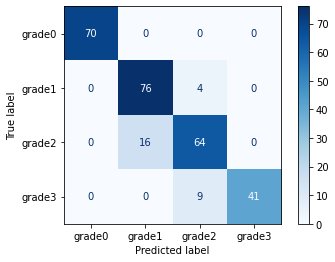

In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)
    all_labels= torch.tensor([], device=device)
    for images,labels in loader:
        images= images.to(device)
        labels= labels.to(device)
        scores = model(images)
        _, preds= scores.max(1)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
    return all_preds, all_labels

with torch.no_grad():
    all_preds, all_labels = get_all_preds(incep_resnet.to(device), test_loader)

cmt= CMT(all_labels.cpu(), all_preds.cpu())
# print(cmt)
# print()
# print(confusion_matrix)
names= sorted(os.listdir(test_dir))
disp= CMD(cmt, names)
disp.plot(cmap='Blues')